### Trying Planet_sample dataset with multi-lable classification for Chapter 6

In [1]:
from fastai.vision.all import *
path = untar_data(URLs.PLANET_SAMPLE)

In [2]:
path.ls()

(#2) [Path('/storage/data/planet_sample/train'),Path('/storage/data/planet_sample/labels.csv')]

In [3]:
df = pd.read_csv(path/'labels.csv')
df.head()

,image_name,tags
0,train_21983,partly_cloudy primary
1,train_9516,clear cultivation primary water
2,train_12664,haze primary
3,train_36960,clear primary
4,train_5302,haze primary road


In [4]:
df['image_name'] = df['image_name'].astype(str) + '.jpg'

In [5]:
df['image_name']

0      train_21983.jpg
1       train_9516.jpg
2      train_12664.jpg
3      train_36960.jpg
4       train_5302.jpg
            ...       
995     train_1876.jpg
996    train_10311.jpg
997    train_19080.jpg
998    train_39339.jpg
999     train_1934.jpg
Name: image_name, Length: 1000, dtype: object

In [6]:
dblock = DataBlock()

In [7]:
dsets = dblock.datasets(df)

In [8]:
len(dsets.train),len(dsets.valid)

(800, 200)

In [9]:
x,y = dsets.train[0]
x,y

(image_name                                      train_26441.jpg
 tags          agriculture habitation partly_cloudy primary road
 Name: 694, dtype: object,
 image_name                                      train_26441.jpg
 tags          agriculture habitation partly_cloudy primary road
 Name: 694, dtype: object)

In [10]:
x['image_name']

'train_26441.jpg'

In [11]:
dblock = DataBlock(get_x = lambda r: r['image_name'], get_y = lambda r: r['tags'])
dsets = dblock.datasets(df)
dsets.train[0]

('train_6049.jpg', 'clear water')

In [12]:
def get_x(r): return r['image_name']
def get_y(r): return r['tags']
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

('train_38901.jpg', 'agriculture bare_ground clear primary')

In [13]:
def get_x(r): return path/'train'/r['image_name']
def get_y(r): return r['tags'].split(' ')
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/storage/data/planet_sample/train/train_18879.jpg'),
 ['partly_cloudy', 'primary'])

In [14]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=get_x, 
                   get_y=get_y,
                  )
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=256x256,
 TensorMultiCategory([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]))

In [15]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=ColReader(0, pref=path/'train'), 
                   get_y=ColReader(1, label_delim=' '),
                  )
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=256x256,
 TensorMultiCategory([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.]))

#### If this would work, I would then do this:

In [24]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=RandomSplitter(seed=42),
                   get_x=ColReader(0, pref=path/'train'), 
                   get_y=ColReader(1, label_delim=' '),
                   item_tfms=RandomResizedCrop(128, min_scale=0.7),
                   batch_tfms=aug_transforms(),
                   )
dls = dblock.dataloaders(df)

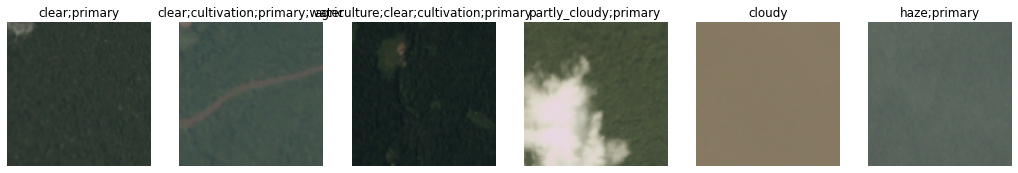

In [25]:
dls.show_batch(nrows=1, ncols=6)

In [26]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(8, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.983993,0.700011,0.272059,00:06
1,0.925150,0.637987,0.339706,00:06
2,0.861343,0.589176,0.404412,00:06
3,0.788517,0.447346,0.418235,00:06


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.536334,0.426963,0.422941,00:07
1,0.504936,0.394353,0.514412,00:07
2,0.458110,0.302275,0.616765,00:07
3,0.409301,0.229032,0.832059,00:07
4,0.362681,0.222123,0.899412,00:07
5,0.324315,0.200062,0.920294,00:07
6,0.292243,0.179581,0.930588,00:07
7,0.268306,0.176192,0.931765,00:07


#### Picking the right threshold:

In [27]:
preds,targs = learn.get_preds()

In [28]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

TensorImage(0.9309)

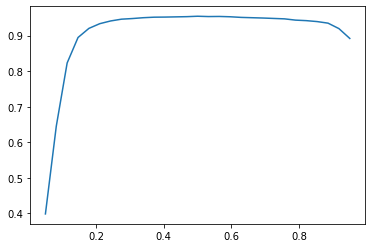

In [29]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

#### Here could be the plot.

In [30]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.5))
learn.fine_tune(5, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.995244,0.751766,0.556176,00:06
1,0.929966,0.632052,0.667647,00:06
2,0.859922,0.613475,0.680588,00:06
3,0.782763,0.440633,0.846176,00:06


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.538371,0.458237,0.849706,00:07
1,0.501685,0.382483,0.905294,00:07
2,0.448685,0.303499,0.929706,00:07
3,0.401988,0.247143,0.948235,00:07
4,0.364708,0.236034,0.948824,00:07


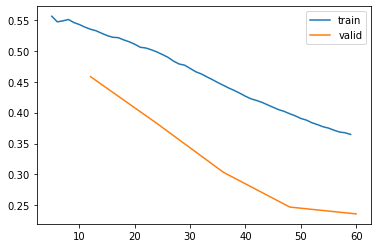

In [31]:
learn.recorder.plot_loss()

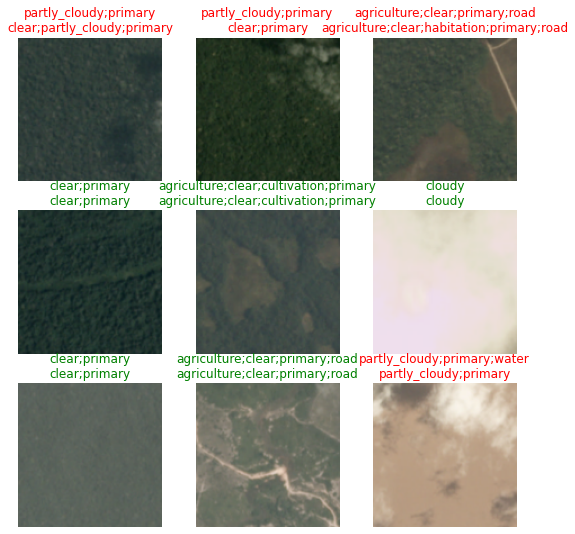

In [32]:
learn.show_results()